# Regression Models

### Imports

In [202]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from own_functions import custom_dropper, model_classification

### Settings

In [203]:
# Pandas configuration
pd.options.display.max_rows = 100 # For debugging, can be removed later

# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]

# Random Forest Regression

### Helper functions
Sort out in the end!!!

In [204]:
def reduce_features_lda_border(df, df_train, cols, target, border=100):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(df_train[cols])
    df_scaled_train = pd.DataFrame(data=scaled_train, columns=cols)
    lda = LDA(n_components=1)
    lda.fit(df_scaled_train.dropna(),
                        np.where(custom_dropper(df_train, cols)[target] > border, 1, 0).tolist())
    
    scaled_test = scaler.transform(df[cols])
    df_scaled_test = pd.DataFrame(data=scaled_test, columns=cols)
    lda_comps = lda.transform(df_scaled_test.dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[cols].dropna().index
    return lda_df

In [205]:
def reduce_features_lda_bins(df, df_train, cols, target, n_comps=2, n_bins=2):
    '''
    df
    cols
    '''
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_train[cols])
    df_scaled = pd.DataFrame(data=scaled, columns=cols)
    lda = LDA(n_components=n_comps)
    lda.fit(df_scaled.dropna(),
            pd.cut(custom_dropper(df_train, cols)[target], n_bins, labels=False))
    
    scaled_test = scaler.transform(df[cols])
    df_scaled_test = pd.DataFrame(data=scaled_test, columns=cols)
    lda_comps = lda.transform(df_scaled_test.dropna())
    lda_df = pd.DataFrame(data = lda_comps)
    lda_df.index = df[cols].dropna().index
    return lda_df

### Loading and preparing the data

In [206]:
sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = pickle.load(open('data_subsets_lags.pickle', 'rb'))

In [207]:
sj_train = pd.concat([sj_train_train, sj_train_test], axis=0)
iq_train = pd.concat([iq_train_train, iq_train_test], axis=0)

## Random Forest Regression
## Part 1: San Juan Validation

### Feature selection

In [208]:
def get_env_features(df):
    '''
    Retrieve a list of column names that refer to columns that contain variables that can be used to train a model.
    -------------------------
    In: data frame
    -------------------------
    Out: list of column names
    '''
    return (
        df.drop([
          'total_cases',
           'week_start_date',
           'city',
           'year',
           'weekofyear'
        ], axis=1)
        .columns
        .to_list()
    )
env_features = get_env_features(sj_train_train)

In [209]:
def get_highest_corr_features(df, n):
    '''
    Retrieve those features that have the highest absolute Pearson correlation.
    -------------------------
    In: 
    df: data frame
    n: number of variables to retain
    -------------------------
    Out: list of column names
    '''
    corr_mat = df.corr()
    return (
        corr_mat['total_cases']
        .drop([
            'total_cases',
            'year',
            'weekofyear'])
        .abs()
        .sort_values()
        .tail(n)
        .index
    )
my_features = get_highest_corr_features(sj_train_train, 7)

### Preprocessing for Sklearn

In [210]:
X_train = sj_train_train[my_features].dropna()
X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

### Scaling

In [211]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logarithmising

In [212]:
# adding 1 to avoid log(0)
y_train = np.log(y_train+1)
y_test = np.log(y_test+1)

### Regression

A Grid Search is avoided here, as with the regularisation gained from it, the predictive power for the vaidation data drastically decreases (not much deviance from the mean).

In [213]:
rf = RandomForestRegressor(max_depth=10)

In [214]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [215]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

### Postprocessing

In [216]:
# Train part
y_train_pred = pd.Series(np.exp(y_train_pred))
y_train_pred -= 1
y_train_pred.index = y_train.index

y_train = np.exp(y_train)
y_train -= 1

# Test part
y_test_pred = pd.Series(np.exp(y_test_pred))
y_test_pred -= 1
y_test_pred.index = y_test.index

y_test = np.exp(y_test)
y_test -= 1

### Smoothing

In [217]:
def lossless_centered_smoothing(test_pred, train_y, w=3, train=False):
    '''
    Applies a centered rolling mean smoothing to the predictions, 
    while avoiding to generate missing values at the begiiing and the end.
    This is done by including data from the training set and using a non-centered
    smoothing (only) for the last data points.
    -----------------------
    In:
    test_pred: pandas Series of interest
    train_y: training set to fill the first values of test_pred
    w: window size for smoothing
    test: whether the function is used for validation/test data or for the 
    train data (for which there are no values to fill-in from another data frame)
    ------------------------
    Out: smoothened Pandas Series with the same length as the input
    '''
    if w // 2 == 0:
        print('w has to be an odd number to keep things simple while still doing centered smoothing')
        return
    else:
        
        trunk = train_y.rolling(window=w).mean()[-int((w-1) / 2):]
        tail = test_pred.rolling(window=w).mean()[-int((w-1) / 2):]

        smoothed = test_pred.rolling(window=w, center=True).mean()
        smoothed[-int((w-1) / 2):] = tail
        if train == False:
            smoothed[:int((w-1) / 2)] = trunk

    return smoothed

### Evaluation

In [218]:
def evaluate_pred_val(y, y_pred, y_train, w, train=False):
    '''
    Get a quick plot of the model and its smoothed version plus evaluation metrics of both. 
    Only for the validation part (when there are actual known values of the taget variable).
    ------------------
    In:
    y: the actual values of the target
    y_pred: the predictions of the model
    y_train: training data (only to fill missing values while smoothing)
    w: window size for smoothing
    test: whether the function is used for validation data or for the 
    train data (for which there are no values to fill-in from another data frame)
    ------------------
    Out: only plots and printed lines
    '''
    y.plot()
    y_pred.plot()
    lossless_centered_smoothing(y_pred, y_train, w=w, train=train).plot();
    print('Raw:')
    model_classification(y, y_pred)
    print('\nWith smoothing:')
    model_classification(y.iloc[int((w-1)/2):], lossless_centered_smoothing(y_pred, y_train, w=w, train=True).dropna())

Raw:
--------------------
RMSE: 36.09
--------------------
MAE: 14.62
Explained variance: 0.622
--------------------

With smoothing:
--------------------
RMSE: 37.91
--------------------
MAE: 15.23
Explained variance: 0.582
--------------------


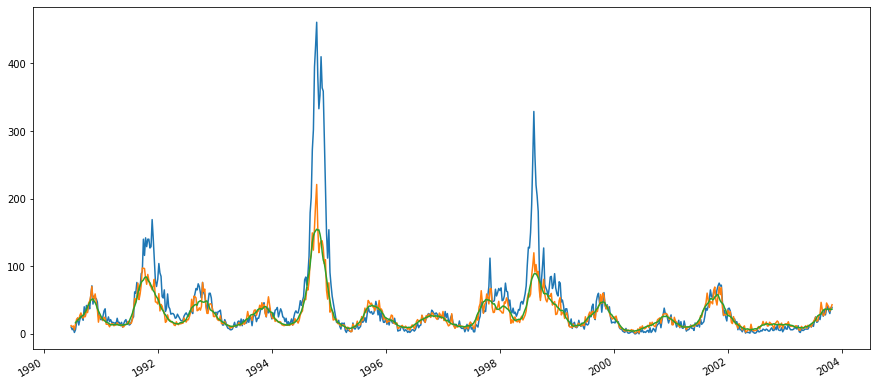

In [219]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

Raw:
--------------------
RMSE: 23.93
--------------------
MAE: 16.55
Explained variance: 0.341
--------------------

With smoothing:
--------------------
RMSE: 22.07
--------------------
MAE: 15.74
Explained variance: 0.455
--------------------


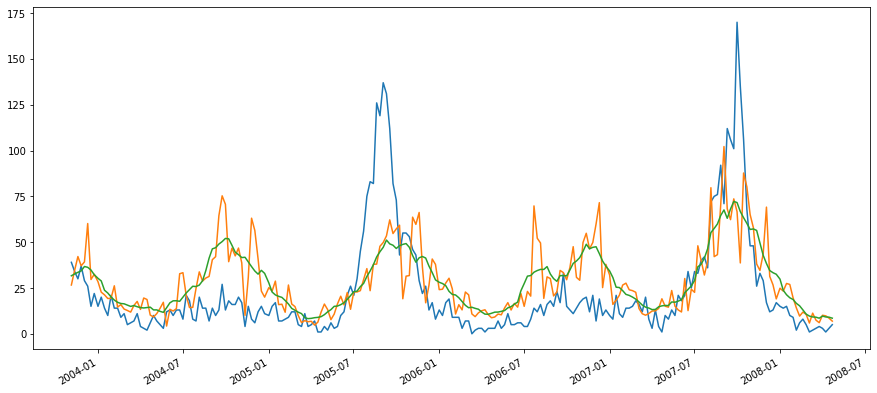

In [220]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=9)

## Part 2: San Juan Test Data

### Feature selection

In [221]:
env_features = get_env_features(sj_train)

In [222]:
my_features = get_highest_corr_features(sj_train, 7)

### Preprocessing for Sklearn

In [223]:
X_train = sj_train[my_features].dropna()
X_test = sj_test[my_features].dropna()

y_train = custom_dropper(sj_train, my_features).total_cases

### Scaling

In [224]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logarithmising

In [225]:
# adding 1 to avoid log(0)
y_train = np.log(y_train+1)

### Regression

In [226]:
rf = RandomForestRegressor(max_depth=10)

In [227]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [228]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

### Postprocessing

In [229]:
# Train part
y_train_pred = pd.Series(np.exp(y_train_pred))
y_train_pred -= 1
y_train_pred.index = y_train.index

y_train = np.exp(y_train)
y_train -= 1

# Test part
y_test_pred = pd.Series(np.exp(y_test_pred))
y_test_pred -= 1
y_test_pred.index = sj_test.index

y_test = np.exp(y_test)
y_test -= 1

### Evaluation

Raw:
--------------------
RMSE: 34.18
--------------------
MAE: 13.69
Explained variance: 0.59
--------------------

With smoothing:
--------------------
RMSE: 35.59
--------------------
MAE: 14.37
Explained variance: 0.555
--------------------


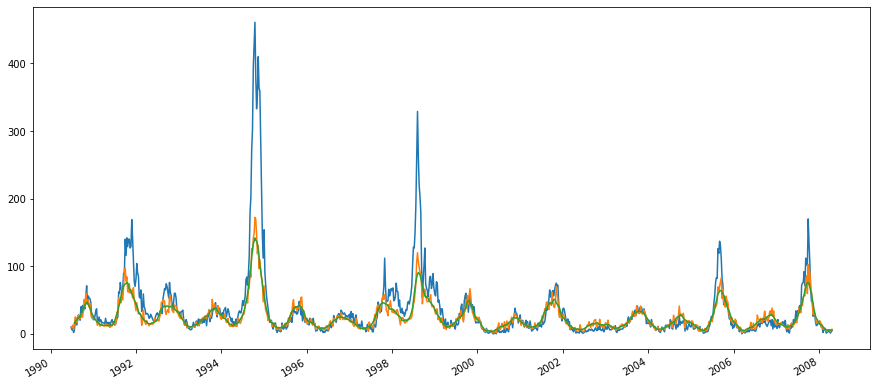

In [230]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

In [231]:
def evaluate_pred_test(y_pred, y_train, w):
    '''
    Get a quick plot of the model and its smoothed version. 
    Only for the test part (when there are no actual known values of the taget variable).
    ------------------
    In:
    y_pred: the predictions of the model
    y_train: training data (only to fill missing values while smoothing)
    w: window size for smoothing
    ------------------
    Out: only plots
    '''
    y_pred.plot(color='C01')
    lossless_centered_smoothing(y_pred, y_train, w=w).plot(color='C02');

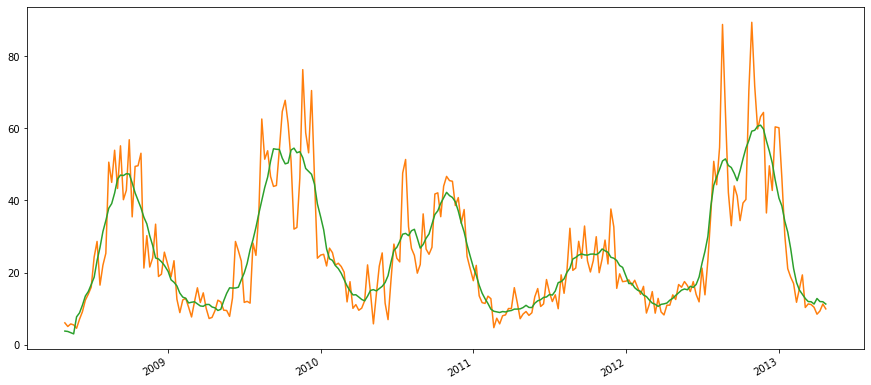

In [232]:
evaluate_pred_test(y_test_pred, y_train, w=9)

In [233]:
# Save the predictions for the submission
sj_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=9)

## Part 3: Iquitos Validation

### Feature selection

In [234]:
env_features = get_env_features(iq_train_train)

In [235]:
my_features = get_highest_corr_features(iq_train_train, 7)

### Preprocessing for Sklearn

In [236]:
X_train = iq_train_train[my_features].dropna()
X_test = iq_train_test[my_features].dropna()

y_train = custom_dropper(iq_train_train, my_features).total_cases
y_test = custom_dropper(iq_train_test, my_features).total_cases

### Scaling

In [237]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logarithmising

In [238]:
# adding 1 to avoid log(0)
y_train = np.log(y_train+1)
y_test = np.log(y_test+1)

### Regression

In [239]:
rf = RandomForestRegressor(max_depth=10)

In [240]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [241]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

### Postprocessing

In [242]:
# Train part
y_train_pred = pd.Series(np.exp(y_train_pred))
y_train_pred -= 1
y_train_pred.index = y_train.index

y_train = np.exp(y_train)
y_train -= 1

# Test part
y_test_pred = pd.Series(np.exp(y_test_pred))
y_test_pred -= 1
y_test_pred.index = y_test.index

y_test = np.exp(y_test)
y_test -= 1

### Evaluation

Raw:
--------------------
RMSE: 7.36
--------------------
MAE: 3.2
Explained variance: 0.603
--------------------

With smoothing:
--------------------
RMSE: 8.97
--------------------
MAE: 4.22
Explained variance: 0.401
--------------------


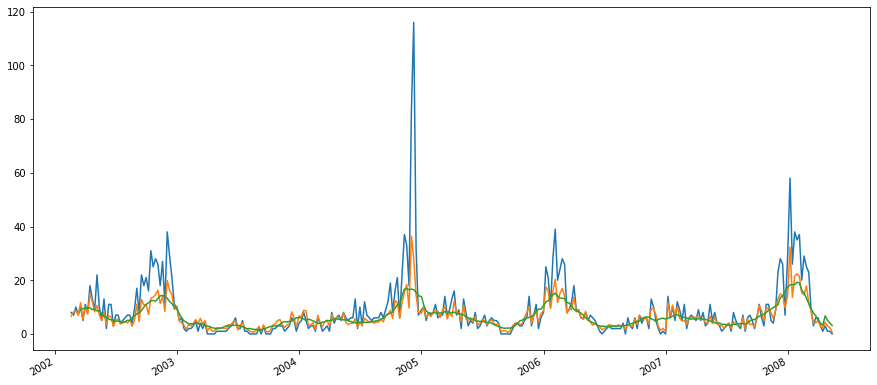

In [243]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

Raw:
--------------------
RMSE: 11.85
--------------------
MAE: 6.96
Explained variance: -0.03
--------------------

With smoothing:
--------------------
RMSE: 11.9
--------------------
MAE: 6.86
Explained variance: -0.012
--------------------


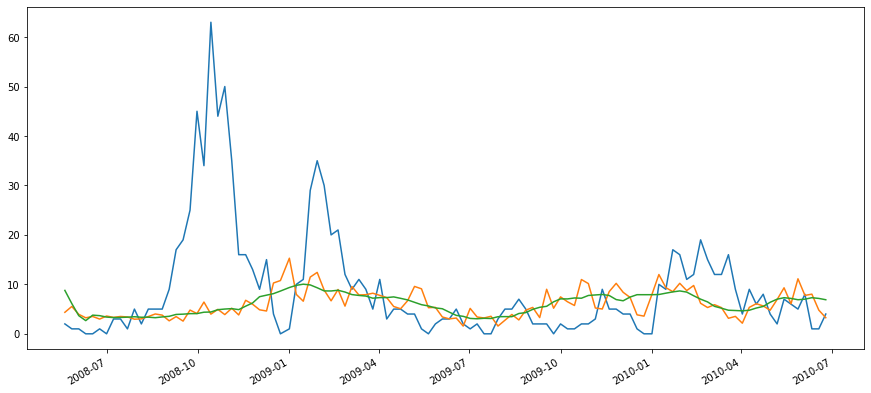

In [244]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=9)

## Part 3: Iquitos Test Data

### Feature selection

In [245]:
env_features = get_env_features(iq_train)

In [246]:
my_features = get_highest_corr_features(iq_train, 7)

### Preprocessing for Sklearn

In [247]:
X_train = iq_train[my_features].dropna()
X_test = iq_test[my_features].dropna()

y_train = custom_dropper(iq_train, my_features).total_cases

### Scaling

In [248]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logarithmising

In [249]:
# adding 1 to avoid log(0)
y_train = np.log(y_train+1)

### Regression

In [250]:
rf = RandomForestRegressor(max_depth=10)

In [251]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [252]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

### Postprocessing

In [253]:
# Train part
y_train_pred = pd.Series(np.exp(y_train_pred))
y_train_pred -= 1
y_train_pred.index = y_train.index

y_train = np.exp(y_train)
y_train -= 1

# Test part
y_test_pred = pd.Series(np.exp(y_test_pred))
y_test_pred -= 1
y_test_pred.index = iq_test.index

y_test = np.exp(y_test)
y_test -= 1

### Evaluation

Raw:
--------------------
RMSE: 7.16
--------------------
MAE: 3.49
Explained variance: 0.634
--------------------

With smoothing:
--------------------
RMSE: 8.89
--------------------
MAE: 4.37
Explained variance: 0.42
--------------------


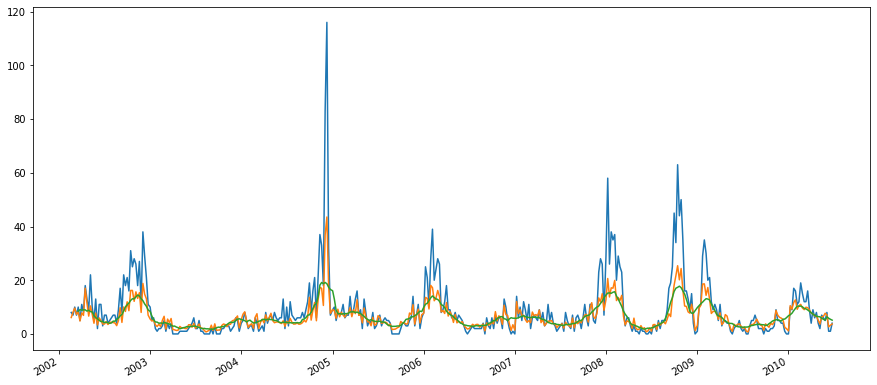

In [254]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

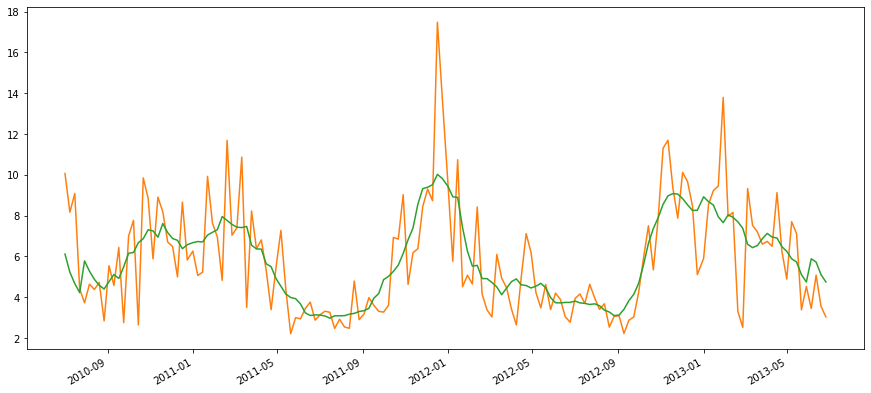

In [255]:
evaluate_pred_test(y_test_pred, y_train, w=9)

In [256]:
# Save the predictions for the submission
iq_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=9)

## Submission

In [257]:
def subm_builder_ind_city(pred, test_df):
    pred = pred.reset_index().rename(columns={
        'index': 'week_start_date',
        0: 'total_cases'
    })
    subm_indcity = pd.merge(test_df[['city', 'year', 'weekofyear','week_start_date']], pred).drop('week_start_date', axis=1)
    return subm_indcity

def subm_builder(pred_1, test_df_1, pred_2, test_df_2):
    '''
    Building a submission file from th epredictions for uploading it to DrivenData.
    ------------------
    In:
    pred_1: predictions for San Juan (pandas series)
    test_df_1: test data frame for San Juan (for the metadata that is not directly in the index of the prediction)
    pred_2: predictions for Iquitos (pandas series)
    test_df_2: test data frame for Iquitos (for the metadata that is not directly in the index of the prediction)
    -------------------
    Out: the submission as a dataframe (for inspection prior to submission)
    '''
    subm_city_1 = subm_builder_ind_city(pred_1, test_df_1)
    subm_city_2 = subm_builder_ind_city(pred_2, test_df_2)
    subm_table = pd.concat([subm_city_1, subm_city_2], axis=0)
    subm_table.total_cases = subm_table.total_cases.astype(int)
    return subm_table

In [258]:
submission_df = subm_builder(sj_pred_subm, sj_test, iq_pred_subm, iq_test)
submission_df

,city,year,weekofyear,total_cases
0,sj,2008,18,3
1,sj,2008,19,3
2,sj,2008,20,3
3,sj,2008,21,3
4,sj,2008,22,7
...,...,...,...,...
151,iq,2013,22,4
152,iq,2013,23,5
153,iq,2013,24,5
154,iq,2013,25,5


In [259]:
# Writing the submission to a file that can be uploaded to DrivenData
submission_df.to_csv('data/submission_simple_random_forest_7_feats.csv', index=False)

# Poisson Regression

## Part 1: San Juan Validation

### Feature selection

In [260]:
env_features = get_env_features(sj_train_train)
my_features = get_highest_corr_features(sj_train_train, 50)

### Preprocessing for Sklearn

In [261]:
X_train = sj_train_train[my_features].dropna()
X_test = sj_train_test[my_features].dropna()

y_train = custom_dropper(sj_train_train, my_features).total_cases
y_test = custom_dropper(sj_train_test, my_features).total_cases

### Scaling

In [262]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [263]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [264]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [265]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [266]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

### Evaluation

Raw:
--------------------
RMSE: 5.73
--------------------
MAE: 4.18
Explained variance: 0.99
--------------------

With smoothing:
--------------------
RMSE: 13.9
--------------------
MAE: 8.06
Explained variance: 0.94
--------------------


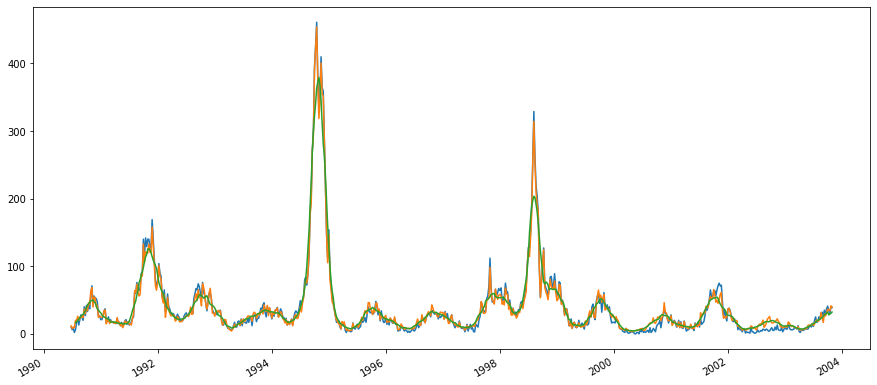

In [267]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

Raw:
--------------------
RMSE: 26.52
--------------------
MAE: 18.19
Explained variance: 0.16
--------------------

With smoothing:
--------------------
RMSE: 25.14
--------------------
MAE: 17.55
Explained variance: 0.258
--------------------


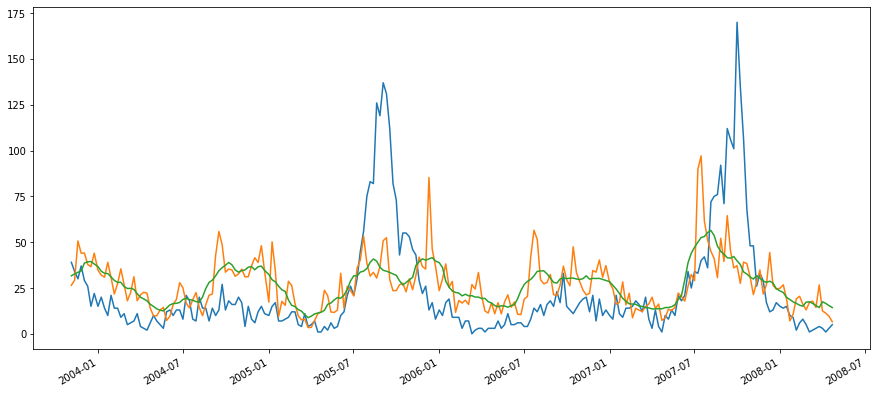

In [268]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=9)

## Part 2: San Juan Test Data

### Feature selection

In [269]:
env_features = get_env_features(sj_train)
my_features = get_highest_corr_features(sj_train, 50)

### Preprocessing for Sklearn

In [270]:
X_train = sj_train[my_features].dropna()
X_test = sj_test[my_features].dropna()

y_train = custom_dropper(sj_train, my_features).total_cases

### Scaling

In [271]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [272]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [273]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [274]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [275]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = sj_test.index

### Evaluation

Raw:
--------------------
RMSE: 4.83
--------------------
MAE: 3.69
Explained variance: 0.991
--------------------

With smoothing:
--------------------
RMSE: 12.6
--------------------
MAE: 7.21
Explained variance: 0.94
--------------------


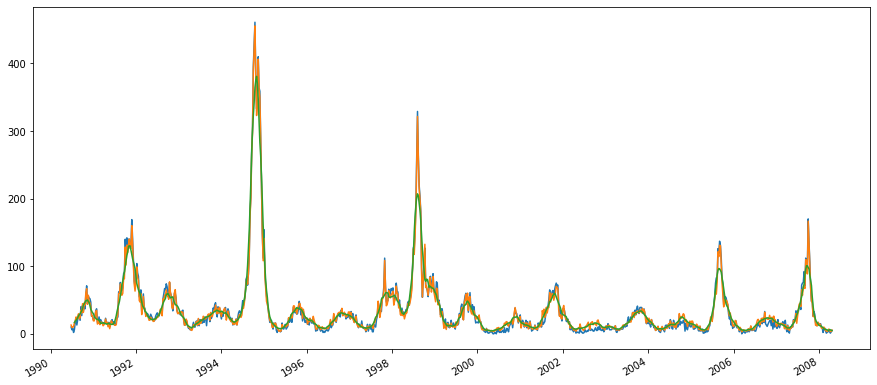

In [276]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

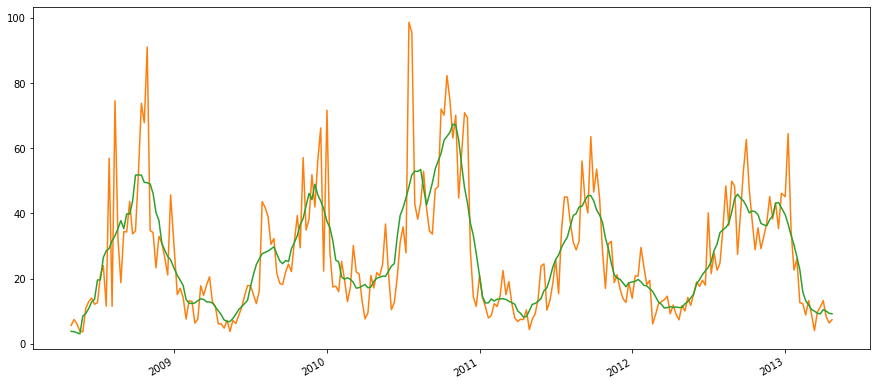

In [277]:
evaluate_pred_test(y_test_pred, y_train, w=9)

In [278]:
# Save the predictions for the submission
sj_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=9)

## Part 3: Iquitos Validation

### Feature selection

In [280]:
env_features = get_env_features(iq_train_train)
my_features = get_highest_corr_features(iq_train_train, 50)

### Preprocessing for Sklearn

In [281]:
X_train = iq_train_train[my_features].dropna()
X_test = iq_train_test[my_features].dropna()

y_train = custom_dropper(iq_train_train, my_features).total_cases
y_test = custom_dropper(iq_train_test, my_features).total_cases

### Scaling

In [282]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [283]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [284]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [285]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [286]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = y_test.index

### Evaluation

Raw:
--------------------
RMSE: 1.41
--------------------
MAE: 1.08
Explained variance: 0.984
--------------------

With smoothing:
--------------------
RMSE: 6.99
--------------------
MAE: 3.58
Explained variance: 0.617
--------------------


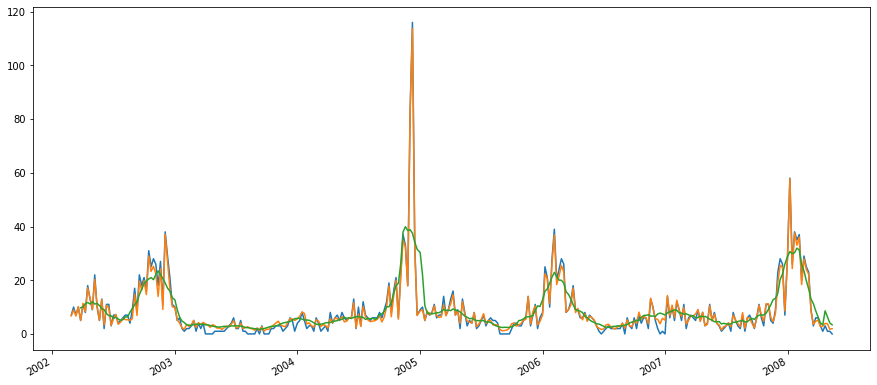

In [287]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

Raw:
--------------------
RMSE: 11.31
--------------------
MAE: 6.96
Explained variance: 0.012
--------------------

With smoothing:
--------------------
RMSE: 11.42
--------------------
MAE: 6.96
Explained variance: 0.013
--------------------


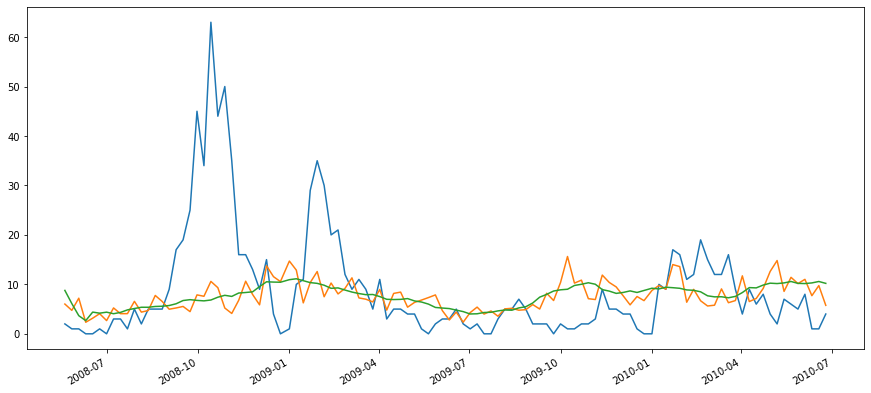

In [288]:
evaluate_pred_val(y_test, y_test_pred, y_train, w=9)

## Part 3: Iquitos Test Data

### Feature selection

In [291]:
env_features = get_env_features(iq_train)
my_features = get_highest_corr_features(iq_train, 50)

### Preprocessing for Sklearn

In [292]:
X_train = iq_train[my_features].dropna()
X_test = iq_test[my_features].dropna()

y_train = custom_dropper(iq_train, my_features).total_cases

### Scaling

In [293]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression

In [294]:
pr = HistGradientBoostingRegressor(loss='poisson')

In [295]:
pr.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [296]:
y_train_pred = pr.predict(X_train)
y_test_pred = pr.predict(X_test)

### Postprocessing

In [297]:
# Train part
y_train_pred = pd.Series(y_train_pred)
y_train_pred.index = y_train.index

# Test part
y_test_pred = pd.Series(y_test_pred)
y_test_pred.index = iq_test.index

### Evaluation

Raw:
--------------------
RMSE: 1.36
--------------------
MAE: 1.07
Explained variance: 0.985
--------------------

With smoothing:
--------------------
RMSE: 6.58
--------------------
MAE: 3.5
Explained variance: 0.66
--------------------


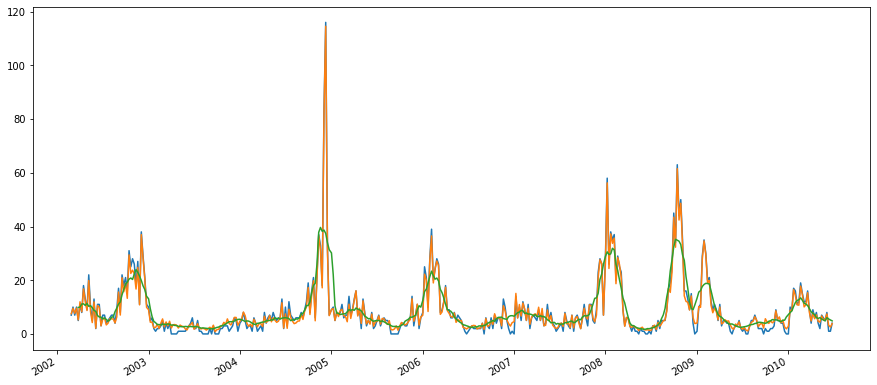

In [299]:
evaluate_pred_val(y_train, y_train_pred, y_train, w=9, train=True)

In [300]:
def evaluate_pred_test(y_pred, y_train, w):
    y_pred.plot(color='C01')
    lossless_centered_smoothing(y_pred, y_train, w=w).plot(color='C02');

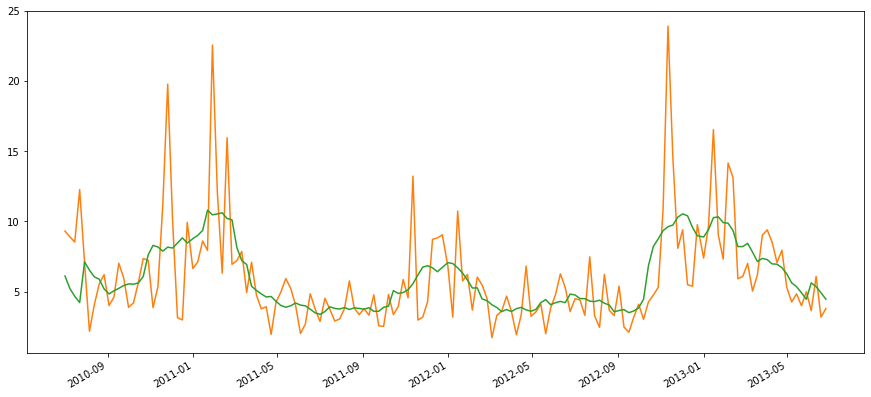

In [301]:
evaluate_pred_test(y_test_pred, y_train, w=9)

In [302]:
# Save the predictions for the submission
iq_pred_subm = lossless_centered_smoothing(y_test_pred, y_train, w=9)

## Submission

In [303]:
submission_df = subm_builder(sj_pred_subm, sj_test, iq_pred_subm, iq_test)
submission_df

,city,year,weekofyear,total_cases
0,sj,2008,18,3
1,sj,2008,19,3
2,sj,2008,20,3
3,sj,2008,21,3
4,sj,2008,22,8
...,...,...,...,...
151,iq,2013,22,4
152,iq,2013,23,5
153,iq,2013,24,5
154,iq,2013,25,4


In [304]:
submission_df.to_csv('data/submission_poisson_gradient_boosting_50.csv', index=False)